In [48]:
import commonfunctions as cf # this a custom module found the commonfunctions.py
import cv2
import numpy as np
import os

In [49]:
# Function to perform the perspective transformation
def perspective_transform(img,binary):

    if img is None:
        print(f"Error: Unable to load the image.")
    else:
        # Convert the image to grayscale
        binary_image=0
        if binary==0:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply thresholding to create a binary image
            _, binary_image = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        else :
            binary_image=img
        # cf.show_images([binary_image])
        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        # print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])

        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, img.shape[0]], [img.shape[1], img.shape[0]], [0, 0], [img.shape[1], 0]])

        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))
        height,width=[warped_img.shape[0],warped_img.shape[1]]
        zoom=20
        zoomed_in_image = warped_img[zoom:height-zoom, zoom:width-zoom]
        return zoomed_in_image
def split_image(binary_image,dilated_img):

    if binary_image is None:
        print(f"Error: Unable to load the image.")
    else:
        contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Find the largest contour based on area
        # print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])
        # Define the destination points for the perspective transformation
        min_x, min_y = np.min(sorted_corners, axis=0)
        max_x, max_y = np.max(sorted_corners, axis=0)

        # Crop the region of interest from the original image
        bubble_sheet_section = binary_image[min_y:max_y, min_x:max_x]
        id_section = binary_image[:min_y, 0:binary_image.shape[1]]

        return [bubble_sheet_section,id_section]
# # Path to the folder containing images
# folder_path = './sample/'

# # List all files in the folder
# image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
# cnt=0
# # Process each image
# for image_file in image_files:
#     image_path = os.path.join(folder_path, image_file)
#     # print(image_path)
#     if(cnt==0):
#         
# _images([perspective_transform(image_path)])
#     cnt+=1


In [50]:
image_path='./sample/sample (15).jpg'

img=cv2.imread(image_path, cv2.IMREAD_COLOR)
def invert_image(img):
    alpha = 0.7  # Contrast control (0.0-3.0)
    beta = -50   # Brightness control (-100 to 100)
    adjusted_img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
    # cf.show_images([adjusted_img])
    img=perspective_transform(adjusted_img,0)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,91, 5)
    thresh_image=255-thresh_image
    trial = perspective_transform(thresh_image,1)
    # cf.show_images([thresh_image])
    transform=perspective_transform(thresh_image,1)
    return transform

def show_bubbels(img):
    kernel = np.ones((2, 2), np.uint8)
    dilated_img = cv2.erode(img, kernel, iterations=1)
    kernel = np.ones((3, 3), np.uint8)

    return trial

def contour_dilation(img) :
     kernel = np.array((1, 10), np.uint8)
     img = cv2.dilate(img, kernel, iterations=10)
     cf.show_images([img])
     print(img)


In [51]:
def show_selected(img, kernel) :
    # kernel = np.ones((3, 3), np.uint8)
    dilated_img = cv2.dilate(img, kernel, iterations=1)
    # cf.show_images([dilated_img])

    dilated_img = cv2.erode(dilated_img, kernel, iterations=7)
    # cf.show_images([dilated_img])

    dilated_img = cv2.dilate(dilated_img, kernel, iterations=15)
    dilated_img = cv2.erode(dilated_img, kernel, iterations=6)
    dilated_img = cv2.dilate(dilated_img, kernel, iterations=8)


    return [img,dilated_img]

In [52]:
def set_whole_rows_to_zero(binary_image, num_rows=5):
    # Copy the binary image to avoid modifying the original
    modified_binary_image = np.copy(binary_image)

    # Set the values of the specified number of rows to 0
    modified_binary_image[:num_rows, :] = 0
    modified_binary_image[-num_rows:, :] = 0

    return modified_binary_image
def set_whole_columns_to_zero(binary_image, num_columns=5):
    # Copy the binary image to avoid modifying the original
    modified_binary_image = np.copy(binary_image)

    # Set the values of the specified number of rows to 0
    modified_binary_image[:,0:num_columns] = 0
    modified_binary_image[:, -num_columns:] = 0 

    return modified_binary_image

In [53]:

# def remove_white_border(binary_image):
    
#     while np.any(binary_image[0, :]) :
#         # Check and remove one-pixel white border
#         binary_image = binary_image[1:-1, 1:-1]

#     return binary_image
def pre_process(img):
    binary_image=invert_image(img)
    black_binary_image = set_whole_rows_to_zero(binary_image,20)
    black_binary_image = set_whole_columns_to_zero(black_binary_image,20)
    # cf.show_images([binary_image,test])
    kernel = np.ones((5, 5), np.uint8)
    dilated_img_filtered = cv2.erode(binary_image, kernel, iterations=1)
    kernel = np.ones((10, 30), np.uint8)
    dilated_img = cv2.dilate(dilated_img_filtered, kernel, iterations=12)
    
    # cf.show_images([binary_image,dilated_img,dilated_img_filtered])
    bubbles,id=split_image(binary_image,dilated_img)
    return bubbles,id

# folder_path = './samples/'

# image_path='./samples/sample (14).jpg'
# image=cv2.imread(image_path, cv2.IMREAD_COLOR)
# # pre_process(image)
# # List all files in the folder
# image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
# cnt=0
# # Process each image
# for image_file in image_files:
#     image_path = os.path.join(folder_path, image_file)
#     print(image_path)
#     if(cnt<50):
#         cf.show_images(pre_process(cv2.imread(image_path, cv2.IMREAD_COLOR)))
#     cnt+=1


In [54]:
def extract_contour_regions(image,mask):
    # Find contours in the binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Extract each contour region into smaller images
    full_height_contours = []
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        if h == image.shape[0]:
            # Extract the contour region from the original image
            contour_region = image[y:y + h, x:x + w]

            # Append the contour region to the list
            full_height_contours.append(contour_region)
        
    return full_height_contours
def bubble_vertical_mask(bubble):

    kernel = np.ones((30, 1), np.uint8) #elongate vertically
    mask = cv2.dilate(bubble, kernel, iterations=10)
    kernel2 = np.ones((1, 10), np.uint8)#make numbers touch in the same column
    mask = cv2.dilate(mask, kernel2, iterations=2)
    return mask


image_path='./samples/sample (15).jpg'
image=cv2.imread(image_path, cv2.IMREAD_COLOR)
bubble,id=pre_process(image)

# cf.show_images([mask])
mask =bubble_vertical_mask(bubble)
list=extract_contour_regions(bubble,mask)


In [55]:
def closing_operation(binary_image, kernel_size=30,interations=3):
    # Define a kernel for the closing operation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    
    return closed_image



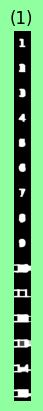

5223.0
4142.5
5536.0
5039.5
4500.0
5458.0
2269.5
2408.5
1406.5
2307.0
2337.0
1652.0
2113.5
2359.5
1477.5
15
2554 0 3215.3333333333335
2554 0 3215.3333333333335
2378 0 3215.3333333333335
2378 0 3215.3333333333335
2202 0 3215.3333333333335
2202 0 3215.3333333333335
2025 0 3215.3333333333335
2024 0 3215.3333333333335
1848 0 3215.3333333333335
1848 0 3215.3333333333335
1701 0 3215.3333333333335
1673 0 3215.3333333333335
1672 0 3215.3333333333335
1494 0 3215.3333333333335
1319 0 3215.3333333333335
1139 0 3215.3333333333335
963 0 3215.3333333333335
787 0 3215.3333333333335
611 0 3215.3333333333335
436 0 3215.3333333333335
259 0 3215.3333333333335
83 0 3215.3333333333335
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


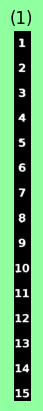

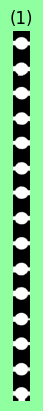

7999.5
7420.0
7381.5
7499.0
7603.0
7653.5
7314.5
7344.0
7495.5
7512.0
7603.0
7517.0
7594.0
7846.5
7361.5
15
2555 0 7542.966666666666
2384 0 7542.966666666666
2204 0 7542.966666666666
2030 0 7542.966666666666
1849 0 7542.966666666666
1677 0 7542.966666666666
1497 0 7542.966666666666
1319 0 7542.966666666666
1138 0 7542.966666666666
967 0 7542.966666666666
788 0 7542.966666666666
617 0 7542.966666666666
437 0 7542.966666666666
313 0 7542.966666666666
268 0 7542.966666666666
86 0 7542.966666666666
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


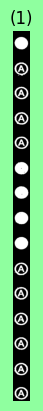

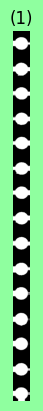

7787.0
7288.5
7285.0
7245.5
7436.0
7558.5
7519.5
7555.5
7598.0
7586.0
7438.0
7253.5
7351.0
7796.0
7533.5
15
2555 0 7482.1
2384 0 7482.1
2204 0 7482.1
2032 0 7482.1
1849 0 7482.1
1677 0 7482.1
1495 0 7482.1
1319 0 7482.1
1138 0 7482.1
968 0 7482.1
789 0 7482.1
618 0 7482.1
438 0 7482.1
314 0 7482.1
268 0 7482.1
87 0 7482.1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


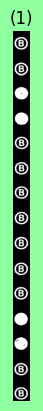

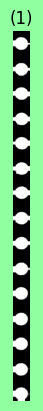

7911.0
7124.0
7119.5
7194.5
7058.0
7613.0
7433.5
7490.0
7570.5
7560.0
7487.5
7439.5
7517.5
7329.5
7380.0
15
2556 0 7415.2
2384 0 7415.2
2204 0 7415.2
2030 0 7415.2
1848 0 7415.2
1676 0 7415.2
1495 0 7415.2
1319 0 7415.2
1139 0 7415.2
968 0 7415.2
790 0 7415.2
619 0 7415.2
440 0 7415.2
268 0 7415.2
86 0 7415.2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


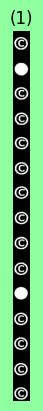

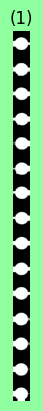

7574.0
7206.5
7389.0
7393.5
7484.5
7636.0
7540.0
7283.5
7333.5
7266.0
7377.5
7448.0
7415.0
7648.5
7453.0
15
2556 0 7429.9
2385 0 7429.9
2205 0 7429.9
2030 0 7429.9
1849 0 7429.9
1676 0 7429.9
1494 0 7429.9
1318 0 7429.9
1139 0 7429.9
969 0 7429.9
791 0 7429.9
620 0 7429.9
441 0 7429.9
269 0 7429.9
88 0 7429.9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


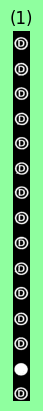

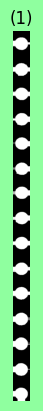

7427.0
7220.0
7470.5
7450.0
7525.5
7422.5
7453.0
7308.0
7291.5
7174.5
7124.0
7474.0
7442.0
7635.0
7449.0
15
2557 0 7391.1
2385 0 7391.1
2204 0 7391.1
2030 0 7391.1
1848 0 7391.1
1675 0 7391.1
1494 0 7391.1
1318 0 7391.1
1139 0 7391.1
969 0 7391.1
792 0 7391.1
621 0 7391.1
443 0 7391.1
270 0 7391.1
89 0 7391.1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


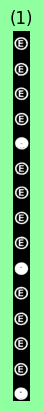

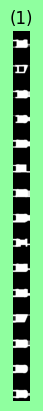

5341.0
5592.0
5961.0
5567.5
5564.5
5586.5
4586.5
6027.5
5810.5
4798.5
5744.0
4833.0
5325.0
4544.0
5216.0
15
2558 0 5366.5
2559 0 5366.5
2382 0 5366.5
2382 0 5366.5
2204 0 5366.5
2203 0 5366.5
2024 0 5366.5
2025 0 5366.5
1847 0 5366.5
1846 0 5366.5
1669 0 5366.5
1668 0 5366.5
1492 0 5366.5
1491 0 5366.5
1318 0 5366.5
1318 0 5366.5
1142 0 5366.5
1141 0 5366.5
969 0 5366.5
968 0 5366.5
794 0 5366.5
793 0 5366.5
620 0 5366.5
619 0 5366.5
444 0 5366.5
444 0 5366.5
268 0 5366.5
266 0 5366.5
236 0 5366.5
88 0 5366.5
88 0 5366.5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


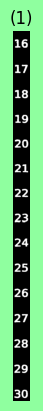

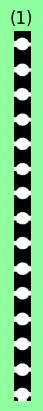

8027.0
7599.5
7566.0
7540.0
7430.5
7548.5
7421.0
7282.5
7322.5
7179.5
7277.5
7130.0
7421.5
7405.0
7421.5
15
2559 0 7438.166666666667
2387 0 7438.166666666667
2205 0 7438.166666666667
2030 0 7438.166666666667
1848 0 7438.166666666667
1675 0 7438.166666666667
1494 0 7438.166666666667
1319 0 7438.166666666667
1141 0 7438.166666666667
972 0 7438.166666666667
794 0 7438.166666666667
623 0 7438.166666666667
445 0 7438.166666666667
273 0 7438.166666666667
90 0 7438.166666666667
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


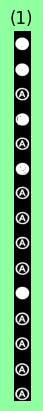

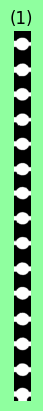

8023.5
7517.5
7422.5
7609.0
7517.0
7439.5
7245.0
7190.5
7257.0
7372.5
7271.5
7272.5
7352.5
7671.0
7596.0
15
2559 0 7450.5
2387 0 7450.5
2205 0 7450.5
2030 0 7450.5
1849 0 7450.5
1675 0 7450.5
1494 0 7450.5
1319 0 7450.5
1104 0 7450.5
1142 0 7450.5
973 0 7450.5
795 0 7450.5
625 0 7450.5
445 0 7450.5
273 0 7450.5
91 0 7450.5
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


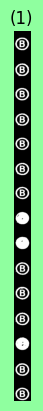

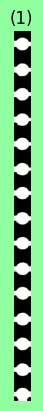

8028.0
7474.5
7570.5
7669.0
7509.0
7539.5
7384.5
7372.5
7248.5
7368.0
7337.5
7300.0
7376.5
7602.0
7646.0
15
2560 0 7495.066666666667
2387 0 7495.066666666667
2205 0 7495.066666666667
2030 0 7495.066666666667
1848 0 7495.066666666667
1675 0 7495.066666666667
1495 0 7495.066666666667
1320 0 7495.066666666667
1142 0 7495.066666666667
973 0 7495.066666666667
795 0 7495.066666666667
624 0 7495.066666666667
445 0 7495.066666666667
272 0 7495.066666666667
90 0 7495.066666666667
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


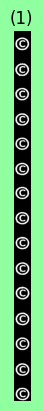

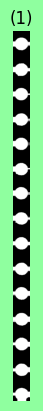

7867.5
7290.5
7481.5
7699.0
7502.0
7404.5
7280.0
7286.5
7215.5
7201.5
7217.0
7236.5
7097.0
7499.5
7580.0
15
2560 0 7390.566666666667
2388 0 7390.566666666667
2206 0 7390.566666666667
2050 0 7390.566666666667
2031 0 7390.566666666667
1849 0 7390.566666666667
1676 0 7390.566666666667
1496 0 7390.566666666667
1321 0 7390.566666666667
1143 0 7390.566666666667
973 0 7390.566666666667
794 0 7390.566666666667
623 0 7390.566666666667
444 0 7390.566666666667
271 0 7390.566666666667
90 0 7390.566666666667
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


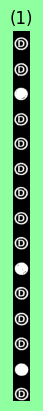

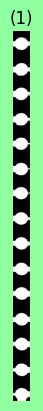

7767.5
7434.5
7620.5
7527.0
7610.0
7599.0
7391.5
7252.0
7163.5
7237.0
7007.5
7425.5
7509.5
7603.0
7611.5
15
2559 0 7450.633333333333
2387 0 7450.633333333333
2206 0 7450.633333333333
2031 0 7450.633333333333
1849 0 7450.633333333333
1676 0 7450.633333333333
1497 0 7450.633333333333
1321 0 7450.633333333333
1142 0 7450.633333333333
972 0 7450.633333333333
793 0 7450.633333333333
621 0 7450.633333333333
443 0 7450.633333333333
270 0 7450.633333333333
88 0 7450.633333333333
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


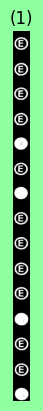

In [79]:
answersPerQuestion=4
# assert(len(list)%(answersPerQuestion+1)==0)
line=list[2]
kernel=np.ones((3,3))
dilated_img = cv2.erode(line, kernel, iterations=5)
contours, _ = cv2.findContours(line, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# for i, contour in enumerate(contours):
#         area = cv2.contourArea(contour)
#         print(f"Contour {i + 1} Area: {area}")

import cv2
import numpy as np

def lit_pixels_in_contour(binary_image):
    # Thresholding (adjust the threshold value as needed)
    # _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Contour detection
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate the contour length
    mask = np.zeros_like(binary_image)

    # List to store lit pixel count along with contours
    bubbles = []

    # Iterate through contours
    for contour in contours:

        x, y, w, h = cv2.boundingRect(contour)

        center_y = y + h // 2
        
        # Draw the contour on the mask
        # cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        # cf.show_images([mask,binary_image])
        # Count the lit pixels within the contour region
        lit_pixel_count = np.count_nonzero(mask & binary_image)
        # print(y,lit_pixel_count)
        bubbles.append((center_y,lit_pixel_count))    
        # Reset the mask
        mask.fill(0)

    # Sort contours based on lit pixel count
    # sorted_contours = sorted(bubbles, key=lambda x: x[0], reverse=True)

    # for y,lit_pixel_count in sorted_contours:
        # print(y,lit_pixel_count)
    return bubbles

def get_centers(binary_image):

    # Contour detection
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # List to store lit pixel count along with contours
    centers = []
        
    total_area=0
    # Iterate through contours
    cf.show_images([binary_image])
    for contour in contours:
    
        print(cv2.contourArea(contour))
        total_area+=cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate the center using bounding box coordinates
        center_y = y + h // 2
        centers.append(center_y)
    avg_area=total_area/len(centers)
    sorted_centers = sorted(centers, key=lambda c: c)

    return sorted_centers,avg_area
def find_closest_index(target_number, number_list):
    return min(range(len(number_list)), key=lambda i: abs(number_list[i] - target_number))


def getAnswers(image):
    # cf.show_images(image)
    closed=closing_operation(image)
    centers,avg_area=get_centers(closed)
    # print(len(centers))
    if(len(centers)>15):
        cf.show_images([closed])
        print(len(centers))
    bubbles=lit_pixels_in_contour(line)
    answered=len(centers)*[0]
    cnt=0
    print(len(centers))
    for y,area in bubbles:
        print(y,area,avg_area)
        if(area>0.75*avg_area):
            cnt+=1
            nearest=find_closest_index(y,centers)
            print(y,centers[nearest],nearest,area,avg_area)
            # print(find_closest_index(y,centers))
            # print(find_closest_index(y,centers))
            # print(len(centers))
            answered[find_closest_index(y,centers)]=1
    # print(cnt)
    # print(answered)
    
    return answered
x=0
numAnswers=4
for line in list:
    answers=getAnswers(line)
    print(answers)
    cf.show_images([line])
# for 
# Example usage:
lit=lit_pixels_in_contour(line)

# lit_pixels_in_contour(line)

# cf.show_images([line])

# lit_pixels_in_contour(list[3])

# # lit_pixels_in_contour(line)

# cf.show_images([list[3]])



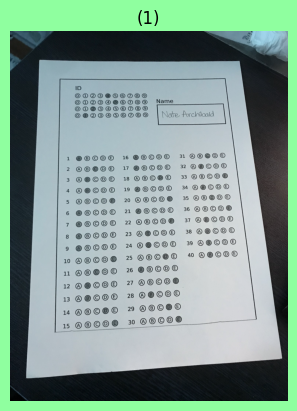

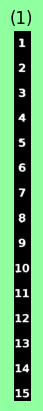

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


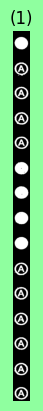

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


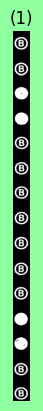

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


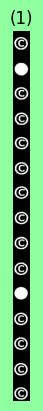

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


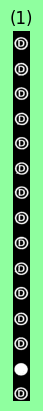

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


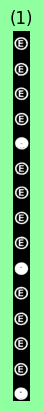

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


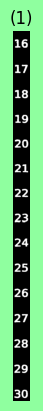

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


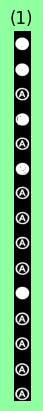

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


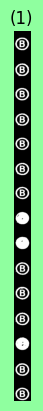

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


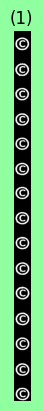

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


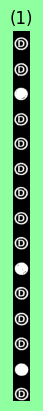

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


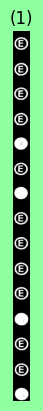

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [71]:
folder_path = './samples/'

image_path='./samples/sample (14).jpg'
image=cv2.imread(image_path, cv2.IMREAD_COLOR)
# pre_process(image)
# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
cnt=0
# Process each image
for image_file in image_files:
    if(cnt>1 and cnt <3):
        image_path = os.path.join(folder_path, image_file)
        image=cv2.imread(image_path, cv2.IMREAD_COLOR) #read image
        bubble,id=pre_process(image) #preprocessing and cutting into two images

        cf.show_images([image])
        mask =bubble_vertical_mask(bubble) # making vertical masks to cut image
        list=extract_contour_regions(bubble,mask) #cut the image into vertical lines
        for line in list:
            answers=getAnswers(line)
            cf.show_images([line])
            print(answers)
        # cf.show_images([line])
    
    cnt+=1


# image_path='./samples/sample (15).jpg'
